In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv("h1b_kaggle.csv")

In [3]:
#  Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


# Clean and prepare data
def clean_h1b_data(df):
    # Remove rows with missing wage values
    df_clean = df.dropna(subset=['PREVAILING_WAGE'])

    # Handle missing values in other columns
    df_clean['WORKSITE'] = df_clean['WORKSITE'].fillna('UNKNOWN')
    df_clean['lon'] = df_clean['lon'].fillna(df_clean['lon'].median())
    df_clean['lat'] = df_clean['lat'].fillna(df_clean['lat'].median())
    df_clean['YEAR'] = df_clean['YEAR'].fillna(df_clean['YEAR'].mode()[0])

    # Remove outliers in wage (optional - use domain knowledge)
    Q1 = df_clean['PREVAILING_WAGE'].quantile(0.25)
    Q3 = df_clean['PREVAILING_WAGE'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Keep reasonable wages (you can adjust these bounds)
    df_clean = df_clean[
        (df_clean['PREVAILING_WAGE'] >= 20000) & 
        (df_clean['PREVAILING_WAGE'] <= 300000)
    ]

    print(f"Dataset size after cleaning: " + str(df_clean.shape))
    print(f"Wage range: $" + str(df_clean['PREVAILING_WAGE'].min()) + " - $" + str(df_clean['PREVAILING_WAGE'].max()))  

    
    return df_clean

In [4]:
data = reduce_mem_usage(data)
# Apply cleaning
df_clean = clean_h1b_data(data.copy())
print(f"Dataset cleaned: {df_clean.shape[0]:,} records remaining")          

C:\Users\ASUS\AppData\Local\Temp\ipykernel_23488\375743176.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['WORKSITE'] = df_clean['WORKSITE'].fillna('UNKNOWN')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_23488\375743176.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['lon'] = df_clean['lon'].fillna(df_clean['lon'].median())
C:\Users\ASUS\AppData\Local\Temp\ipykernel_23488\375743176.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

Dataset size after cleaning: (2996853, 11)
Wage range: $20000.0 - $300000.0
Dataset cleaned: 2,996,853 records remaining


In [5]:
df_clean['CASE_STATUS'].value_counts()

CASE_STATUS
CERTIFIED                                             2613553
CERTIFIED-WITHDRAWN                                    202439
DENIED                                                  91390
WITHDRAWN                                               89453
PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED         15
REJECTED                                                    2
INVALIDATED                                                 1
Name: count, dtype: int64

# Feature Engineering 

In [6]:
df_clean['FULL_TIME_POSITION'].value_counts()

FULL_TIME_POSITION
Y    2571220
N     425633
Name: count, dtype: int64

In [7]:
# Create a copy for feature engineering
df_features = df_clean.copy()

# Select relevant features
features_to_use = [
    'CASE_STATUS', 'EMPLOYER_NAME', 'SOC_NAME', 
    'JOB_TITLE', 'FULL_TIME_POSITION', 'YEAR', 
    'WORKSITE', 'lon', 'lat'
]

# Create a simplified dataframe
df_model = df_features[features_to_use + ['PREVAILING_WAGE']].copy()

# Encode binary feature
df_model['FULL_TIME_POSITION'] = (df_model['FULL_TIME_POSITION'] == 'Y').astype(int)

# For high-cardinality categorical variables, 
# use frequency encoding or target encoding
def frequency_encoding(df, column):
    freq = df[column].value_counts(normalize=True)
    return df[column].map(freq)

# Apply frequency encoding to high-cardinality columns
df_model['EMPLOYER_FREQ'] = frequency_encoding(df_model, 'EMPLOYER_NAME')
df_model['JOB_TITLE_FREQ'] = frequency_encoding(df_model, 'JOB_TITLE')
df_model['WORKSITE_FREQ'] = frequency_encoding(df_model, 'WORKSITE')

# Label encode remaining categorical variables
le = LabelEncoder()
df_model['CASE_STATUS_ENCODED'] = le.fit_transform(df_model['CASE_STATUS'])
df_model['SOC_NAME_ENCODED'] = le.fit_transform(df_model['SOC_NAME'])

# Create final feature set
feature_columns = [
    'CASE_STATUS_ENCODED', 'FULL_TIME_POSITION', 
    'YEAR', 'lon', 'lat', 'EMPLOYER_FREQ', 
    'JOB_TITLE_FREQ', 'WORKSITE_FREQ', 'SOC_NAME_ENCODED'
]

X = df_model[feature_columns]
y = df_model['PREVAILING_WAGE']

# IMPORTANT: Check for and handle any remaining NaN values
print("\nChecking for NaN values in features:")
print(X.isnull().sum())

# Fill any remaining NaN values
X = X.fillna(X.median())

# Final check
print("\nNaN values after filling:", X.isnull().sum().sum())
print("Feature matrix shape:", X.shape)
print("Target variable shape:", y.shape)


Checking for NaN values in features:
CASE_STATUS_ENCODED     0
FULL_TIME_POSITION      0
YEAR                    0
lon                     0
lat                     0
EMPLOYER_FREQ          41
JOB_TITLE_FREQ         25
WORKSITE_FREQ           0
SOC_NAME_ENCODED        0
dtype: int64

NaN values after filling: 0
Feature matrix shape: (2996853, 9)
Target variable shape: (2996853,)

NaN values after filling: 0
Feature matrix shape: (2996853, 9)
Target variable shape: (2996853,)


# Train-Test split & scaling

In [8]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: " + str(X_train.shape))
print(f"Test set size: " + str(X_test.shape))

Training set size: (2397482, 9)
Test set size: (599371, 9)


In [9]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'model': model
    }
    
    print(f"{name} Results:")
    print(f"  MAE: $" + str(round(mae, 2)))
    print(f"  RMSE: $" + str(round(rmse, 2)))
    print(f"  R² Score: " + str(round(r2, 4)))

# Find best model
best_model_name = max(results, key=lambda x: results[x]['R2'])
best_model = results[best_model_name]['model']

print(f"\nBest Model: {best_model_name}")
print(f"R² Score: " + str(round(results[best_model_name]['R2'], 4)))


Training Linear Regression...
Linear Regression Results:
  MAE: $16102.29
  RMSE: $23054.7
  R² Score: 0.1658

Training Ridge Regression...
Ridge Regression Results:
  MAE: $16102.29
  RMSE: $23054.7
  R² Score: 0.1658

Training Random Forest...
Linear Regression Results:
  MAE: $16102.29
  RMSE: $23054.7
  R² Score: 0.1658

Training Ridge Regression...
Ridge Regression Results:
  MAE: $16102.29
  RMSE: $23054.7
  R² Score: 0.1658

Training Random Forest...
Random Forest Results:
  MAE: $7068.08
  RMSE: $12254.22
  R² Score: 0.7643

Training Gradient Boosting...
Random Forest Results:
  MAE: $7068.08
  RMSE: $12254.22
  R² Score: 0.7643

Training Gradient Boosting...
Gradient Boosting Results:
  MAE: $13672.66
  RMSE: $20107.46
  R² Score: 0.3654

Best Model: Random Forest
R² Score: 0.7643
Gradient Boosting Results:
  MAE: $13672.66
  RMSE: $20107.46
  R² Score: 0.3654

Best Model: Random Forest
R² Score: 0.7643


# Feature Importance Analysis 


Feature Importance:
               Feature  Importance
8     SOC_NAME_ENCODED    0.322280
6       JOB_TITLE_FREQ    0.151807
3                  lon    0.136083
5        EMPLOYER_FREQ    0.131994
2                 YEAR    0.096193
7        WORKSITE_FREQ    0.063567
4                  lat    0.053446
1   FULL_TIME_POSITION    0.033100
0  CASE_STATUS_ENCODED    0.011531


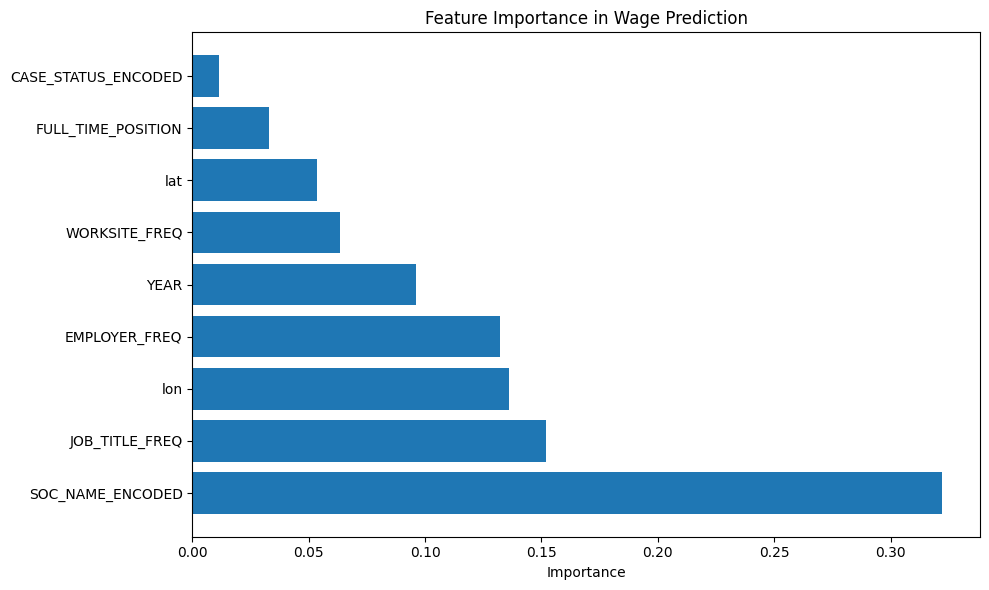

In [10]:
# For tree-based models, we can extract feature importance
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance:")
    print(feature_importance_df)
    
    # Visualize
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance in Wage Prediction')
    plt.tight_layout()
    plt.show()

# Model Evaluation & Visualization

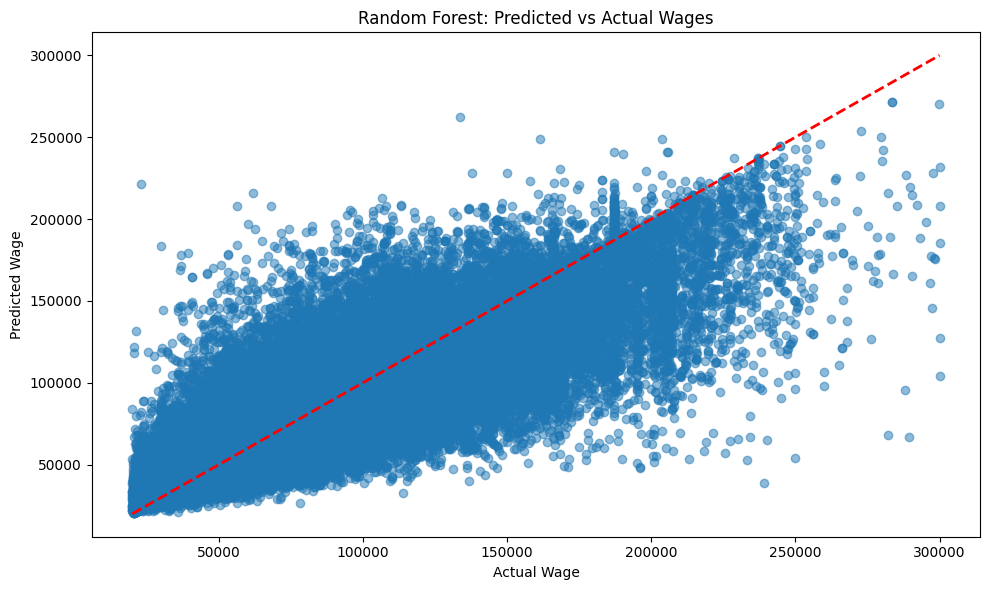

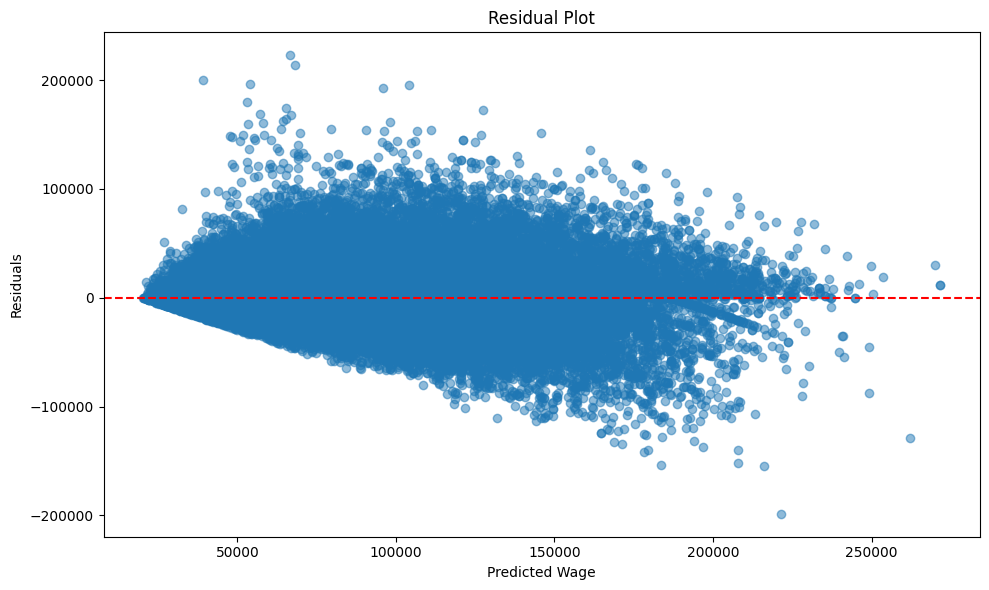

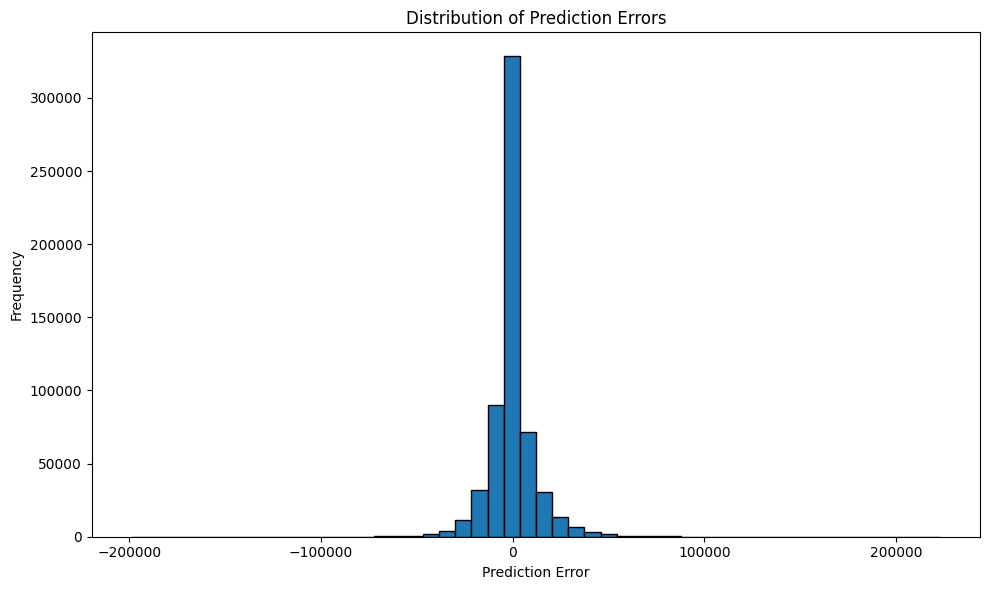

In [11]:
# Make predictions with best model
y_pred_best = best_model.predict(X_test_scaled)

# Create prediction vs actual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         'r--', lw=2)
plt.xlabel('Actual Wage')
plt.ylabel('Predicted Wage')
plt.title(f'{best_model_name}: Predicted vs Actual Wages')
plt.tight_layout()
plt.show()

# Residual plot
residuals = y_test - y_pred_best
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_best, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Wage')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

# Error distribution
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='black')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.tight_layout()
plt.show()

# Save Model Evaluation & Visualization

In [12]:
import pickle

# Save the model and scaler
with open('wage_predictor_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Model saved successfully!")

# Function to make predictions on new data
def predict_wage(new_data):
    """
    new_data should be a dictionary with keys matching feature_columns
    Example:
    new_data = {
        'CASE_STATUS_ENCODED': 1,
        'FULL_TIME_POSITION': 1,
        'YEAR': 2015.0,
        'lon': -122.08,
        'lat': 37.38,
        'EMPLOYER_FREQ': 0.002,
        'JOB_TITLE_FREQ': 0.015,
        'WORKSITE_FREQ': 0.05,
        'SOC_NAME_ENCODED': 45
    }
    """
    # Load model and scaler
    with open('wage_predictor_model.pkl', 'rb') as f:
        model = pickle.load(f)
    with open('feature_scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    
    # Create dataframe
    df_new = pd.DataFrame([new_data])
    
    # Scale
    df_scaled = scaler.transform(df_new)
    
    # Predict
    prediction = model.predict(df_scaled)[0]
    
    return prediction

# # Example prediction
# example_data = {
#     'CASE_STATUS_ENCODED': 1,
#     'FULL_TIME_POSITION': 1,
#     'YEAR': 2015.0,
#     'lon': -122.08,
#     'lat': 37.38,
#     'EMPLOYER_FREQ': 0.002,
#     'JOB_TITLE_FREQ': 0.015,
#     'WORKSITE_FREQ': 0.05,
#     'SOC_NAME_ENCODED': 45
# }

# predicted_wage = predict_wage(example_data)
# print(f"\nPredicted Wage: $" + str(round(predicted_wage, 2)))

Model saved successfully!


In [13]:
# Example prediction
example_data = {
    'CASE_STATUS_ENCODED': 1,
    'FULL_TIME_POSITION': 1,
    'YEAR': 2015.0,
    'lon': -122.08,
    'lat': 37.38,
    'EMPLOYER_FREQ': 0.002,
    'JOB_TITLE_FREQ': 0.015,
    'WORKSITE_FREQ': 0.05,
    'SOC_NAME_ENCODED': 45
}

predicted_wage = predict_wage(example_data)
print(f"\nPredicted Wage: $" + str(round(predicted_wage, 2)))


Predicted Wage: $86141.8


# Custom Input Testing

In [14]:
# Build lookup tables for user-friendly input conversion
print("Building lookup tables from training data...")

# Get unique values from original data
employer_list = sorted(df_model['EMPLOYER_NAME'].dropna().unique())
occupation_list = sorted(df_model['SOC_NAME'].dropna().unique())
worksite_list = sorted(df_model['WORKSITE'].dropna().unique())

# Create mappings for encoding
employer_freq_map = df_model.groupby('EMPLOYER_NAME')['EMPLOYER_FREQ'].first().to_dict()
job_title_freq_map = df_model.groupby('JOB_TITLE')['JOB_TITLE_FREQ'].first().to_dict()
worksite_freq_map = df_model.groupby('WORKSITE')['WORKSITE_FREQ'].first().to_dict()

# Create label encoders for categorical features
le_case = LabelEncoder()
le_case.fit(df_model['CASE_STATUS'])
le_soc = LabelEncoder()
le_soc.fit(df_model['SOC_NAME'])

print(f"✓ Loaded {len(employer_list)} employers")
print(f"✓ Loaded {len(occupation_list)} occupations")
print(f"✓ Loaded {len(worksite_list)} worksites")


Building lookup tables from training data...
✓ Loaded 235384 employers
✓ Loaded 2103 occupations
✓ Loaded 18544 worksites
✓ Loaded 235384 employers
✓ Loaded 2103 occupations
✓ Loaded 18544 worksites


In [15]:
# Function to convert user-friendly input to model features
def convert_user_input_to_features(employer_name, year, occupation, state, area_type):
    """
    Convert user-friendly inputs to model features
    
    Parameters:
    - employer_name (str): Company name
    - year (int): Application year
    - occupation (str): SOC occupation name
    - state (str): State abbreviation (e.g., 'CA', 'NY')
    - area_type (str): Urban/Rural or area classification
    
    Returns:
    - dict: Features ready for model prediction
    """
    
    features = {}
    
    # 1. CASE_STATUS_ENCODED (assume certified for new applications)
    features['CASE_STATUS_ENCODED'] = le_case.transform(['CERTIFIED'])[0]
    
    # 2. FULL_TIME_POSITION (assume yes)
    features['FULL_TIME_POSITION'] = 1
    
    # 3. YEAR
    features['YEAR'] = float(year)
    
    # 4. Get employer frequency
    if employer_name in employer_freq_map:
        features['EMPLOYER_FREQ'] = employer_freq_map[employer_name]
    else:
        features['EMPLOYER_FREQ'] = df_model['EMPLOYER_FREQ'].mean()  # Use mean if employer not found
    
    # 5. Get occupation encoding
    if occupation in le_soc.classes_:
        features['SOC_NAME_ENCODED'] = le_soc.transform([occupation])[0]
    else:
        features['SOC_NAME_ENCODED'] = int(le_soc.transform([le_soc.classes_[0]])[0])  # Default
    
    # 6. Job title frequency (approximate from occupation)
    features['JOB_TITLE_FREQ'] = df_model['JOB_TITLE_FREQ'].mean()
    
    # 7. Worksite frequency
    if area_type.upper() in ['URBAN', 'METRO']:
        features['WORKSITE_FREQ'] = df_model[df_model['WORKSITE_FREQ'] > df_model['WORKSITE_FREQ'].median()]['WORKSITE_FREQ'].mean()
    else:
        features['WORKSITE_FREQ'] = df_model[df_model['WORKSITE_FREQ'] <= df_model['WORKSITE_FREQ'].median()]['WORKSITE_FREQ'].mean()
    
    # 8. Coordinates (approximate based on state)
    # Simple mapping of states to approximate coordinates
    state_coords = {
        'CA': (-120.0, 37.0), 'NY': (-75.5, 43.0), 'TX': (-99.0, 31.0),
        'FL': (-81.5, 27.5), 'IL': (-89.5, 40.0), 'WA': (-120.5, 47.5),
        'MA': (-71.5, 42.5), 'NJ': (-74.5, 40.0), 'PA': (-77.5, 41.0),
        'CO': (-105.5, 39.0), 'AZ': (-111.5, 34.5), 'OH': (-82.5, 40.5),
        'MI': (-85.0, 44.5), 'NC': (-79.5, 35.5), 'GA': (-83.5, 32.5),
        'VA': (-78.5, 37.5), 'MD': (-76.5, 39.0), 'CT': (-72.5, 41.5),
        'MN': (-94.5, 45.5), 'VA': (-78.0, 37.5)
    }
    
    if state.upper() in state_coords:
        lon, lat = state_coords[state.upper()]
    else:
        lon, lat = -95.0, 40.0  # Default to center of US
    
    features['lon'] = lon
    features['lat'] = lat
    
    return features


# Function to determine wage level based on salary
def get_wage_level(salary):
    """
    Classify wage into levels based on percentiles
    """
    wage_percentiles = {
        'Level 1 (Entry)': (0, y_train.quantile(0.25)),
        'Level 2 (Mid-Range)': (y_train.quantile(0.25), y_train.quantile(0.50)),
        'Level 3 (Above Average)': (y_train.quantile(0.50), y_train.quantile(0.75)),
        'Level 4 (Premium)': (y_train.quantile(0.75), float('inf'))
    }
    
    for level, (min_sal, max_sal) in wage_percentiles.items():
        if min_sal <= salary <= max_sal:
            return level
    return 'Level 4 (Premium)'


In [16]:
# CUSTOM INPUT SECTION - USER FRIENDLY
print("\n" + "=" * 80)
print(" " * 20 + "H1B VISA WAGE PREDICTION SYSTEM")
print("=" * 80)

# ==== MODIFY THESE INPUTS ====
employer_name = "MICROSOFT CORPORATION"  # Enter employer name
year = 2019  # Enter year (2010-2020)
occupation = "Computer Systems Analysts"  # Enter SOC occupation name
state = "WA"  # Enter state abbreviation (CA, NY, TX, etc.)
area_type = "URBAN"  # Urban or Rural
# ==== END INPUTS ====

print("\n📋 INPUT PARAMETERS:")
print("-" * 80)
print(f"  Employer:    {employer_name}")
print(f"  Year:        {year}")
print(f"  Occupation:  {occupation}")
print(f"  State:       {state}")
print(f"  Area Type:   {area_type}")
print("-" * 80)

# Convert user inputs to model features
try:
    features = convert_user_input_to_features(employer_name, year, occupation, state, area_type)
    
    # Make prediction
    predicted_salary = predict_wage(features)
    wage_level = get_wage_level(predicted_salary)
    
    # Calculate additional metrics
    monthly_salary = predicted_salary / 12
    hourly_salary = predicted_salary / 2080  # 52 weeks * 40 hours
    
    # Display results
    print("\n✅ PREDICTION RESULTS:")
    print("-" * 80)
    print(f"  Annual Salary:      ${predicted_salary:>15,.2f}")
    print(f"  Monthly Salary:     ${monthly_salary:>15,.2f}")
    print(f"  Hourly Rate:        ${hourly_salary:>15,.2f}")
    print(f"\n  Wage Level:         {wage_level}")
    print("-" * 80)
    
    # Salary range context
    p25 = y_train.quantile(0.25)
    p50 = y_train.quantile(0.50)
    p75 = y_train.quantile(0.75)
    
    print(f"\n📊 MARKET CONTEXT:")
    print(f"  Training Data Range:")
    print(f"    25th Percentile: ${p25:>15,.2f}")
    print(f"    50th Percentile: ${p50:>15,.2f}")
    print(f"    75th Percentile: ${p75:>15,.2f}")
    print("-" * 80)
    
except Exception as e:
    print(f"\n❌ Error: {str(e)}")
    print("\nPlease check your inputs:")
    print(f"  Available occupations (sample): {occupation_list[:5]}")
    print(f"  Available employers (sample): {employer_list[:5]}")



                    H1B VISA WAGE PREDICTION SYSTEM

📋 INPUT PARAMETERS:
--------------------------------------------------------------------------------
  Employer:    MICROSOFT CORPORATION
  Year:        2019
  Occupation:  Computer Systems Analysts
  State:       WA
  Area Type:   URBAN
--------------------------------------------------------------------------------

❌ Error: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


Please check your inputs:
  Available occupations (sample): ['13-2011.01', '15-1121', '15-1132', '15-1199.01', '15-1199.01 SW QUALITY ASSURANCE ENGNRS & TESTERS']
  Available employers (sample): ['"EXCELLENT COMPUTING DISTRIBUTORS INC"', '"I HAVE A DREAM" FOUNDATION', '"K" LINE AMERICA', '"K" LINE AMERICA, INC.', '"K" LINE LOGISITCS (U.S.A.) INC.']

❌ Error: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.
